In [1]:
from multiprocessing.pool import ThreadPool
import numpy as np
import pandas as pd
import sktime
from sktime.datasets import load_from_tsfile
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, precision_score, recall_score)
from sklearn.utils import resample
import xgboost as xgb
import progressbar

C:\Users\Lucas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Lucas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Lucas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Replicating results from [paper](https://link.springer.com/article/10.1007/s10618-020-00727-3)

In [7]:
!ls data

AtrialFibrillation
Epilepsy
FaceDetection
Heartbeat


In [8]:
!ls data/Epilepsy

Epilepsy.jpg
Epilepsy.txt
Epilepsy_TEST.arff
Epilepsy_TEST.ts
Epilepsy_TRAIN.arff
Epilepsy_TRAIN.ts
EpilepsyDimension1_TEST.arff
EpilepsyDimension1_TRAIN.arff
EpilepsyDimension2_TEST.arff
EpilepsyDimension2_TRAIN.arff
EpilepsyDimension3_TEST.arff
EpilepsyDimension3_TRAIN.arff


In [39]:
X_train, y_train = load_from_tsfile('data/Epilepsy/Epilepsy_TRAIN.ts')
len(X_train), len(y_train)

(137, 137)

In [10]:
X_train.iloc[0, 0]

0      0.35
1      0.40
2      0.44
3      0.47
4      0.48
       ... 
201    0.58
202    0.61
203    0.62
204    0.65
205    0.69
Length: 206, dtype: float64

In [11]:
X_train

,dim_0,dim_1,dim_2
0,0 0.35 1 0.40 2 0.44 3 0.4...,0 0.22 1 0.01 2 -0.71 3 -0.3...,0 0.55 1 0.51 2 0.52 3 0.4...
1,0 -0.91 1 -0.92 2 -0.95 3 -0.9...,0 -0.05 1 -0.02 2 0.01 3 0.0...,0 0.06 1 -1.57 2 -0.99 3 0.2...
2,0 0.32 1 0.71 2 0.70 3 0.7...,0 1.00 1 -1.33 2 -1.44 3 -0.1...,0 0.37 1 0.37 2 0.37 3 0.3...
3,0 -0.68 1 -0.36 2 -0.13 3 -0.3...,0 -1.69 1 -0.58 2 1.05 3 -0.1...,0 0.31 1 0.31 2 0.32 3 0.0...
4,0 0.34 1 0.53 2 0.58 3 0.6...,0 -0.89 1 1.17 2 1.00 3 -1.8...,0 0.45 1 -0.05 2 -0.17 3 -0.4...
...,...,...,...
132,0 0.45 1 -0.28 2 0.28 3 1.3...,0 -0.21 1 -1.20 2 -1.26 3 -0.4...,0 -0.58 1 -0.87 2 -0.38 3 -0.0...
133,0 0.24 1 -0.79 2 -0.65 3 0.0...,0 0.50 1 0.69 2 0.86 3 0.6...,0 -0.99 1 -0.99 2 -0.65 3 -0.4...
134,0 1.16 1 -0.02 2 -1.04 3 -0.8...,0 0.90 1 0.59 2 0.52 3 0.2...,0 -1.03 1 -1.11 2 -0.88 3 -0.9...
135,0 -0.74 1 -0.14 2 0.12 3 -0.0...,0 -0.19 1 -0.24 2 -0.34 3 -0.6...,0 -0.14 1 -0.26 2 -0.27 3 -0.3...


In [38]:
X_test, y_test = load_from_tsfile('data/Epilepsy/Epilepsy_TEST.ts')
len(X_test), len(y_test)

(138, 138)

In [13]:
rocket = Rocket()

In [14]:
%%time
rocket.fit(X_train)

CPU times: total: 1.25 s
Wall time: 1.27 s


Rocket()

In [15]:
%%time
X_train_transform = rocket.transform(X_train)

CPU times: total: 7.88 s
Wall time: 7.54 s


In [16]:
X_train_transform

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.397059,8.705517,0.567961,6.607443,0.718447,4.975292,0.698413,4.523936,0.673469,5.387903,...,0.556122,17.628756,0.626214,5.179047,0.457447,10.270067,0.506024,6.897235,0.505050,6.263344
1,0.558824,9.699242,0.699029,5.400214,0.834951,4.498794,0.738095,3.573932,0.647959,9.815283,...,0.596939,6.381762,0.548544,4.975739,0.510638,8.489173,0.355422,4.868214,0.696970,3.130280
2,0.455882,4.818572,0.558252,8.907209,0.674757,8.248878,0.531746,5.430207,0.704082,12.753749,...,0.515306,14.765491,0.655340,9.668018,0.744681,11.353446,0.518072,8.809491,0.484848,5.360727
3,0.720588,8.736917,0.616505,9.211243,0.582524,8.455519,0.761905,3.513715,0.576531,9.244023,...,0.596939,18.883776,0.703883,4.036015,0.148936,13.093062,0.457831,9.606945,0.727273,10.061675
4,0.588235,9.873841,0.597087,5.928568,0.810680,3.491780,0.611111,4.604117,0.551020,12.866261,...,0.535714,16.850950,0.538835,5.435220,0.436170,14.607599,0.403614,8.867060,0.535354,4.864210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.632353,6.016315,0.660194,4.447271,0.563107,7.584338,0.555556,5.498667,0.566327,12.439915,...,0.525510,11.346148,0.529126,6.027164,0.446809,6.994060,0.469880,8.440746,0.500000,5.543283
133,0.352941,4.613958,0.587379,8.375721,0.650485,9.961404,0.603175,4.591414,0.627551,7.052948,...,0.607143,9.485945,0.495146,4.688056,0.617021,14.909966,0.433735,5.271110,0.575758,4.511335
134,0.470588,3.895863,0.543689,8.546111,0.567961,7.695856,0.730159,3.574507,0.622449,7.134107,...,0.530612,11.192828,0.713592,4.027375,0.638298,14.214641,0.421687,2.433496,0.666667,8.193495
135,0.500000,12.270440,0.519417,10.089917,0.572816,6.548789,0.579365,6.195164,0.556122,8.232037,...,0.607143,8.098444,0.495146,5.277418,0.510638,9.682162,0.415663,3.906357,0.656566,3.222535


In [17]:
classifier = RidgeClassifier()

In [18]:
classifier.fit(X_train_transform, y_train)

RidgeClassifier()

In [19]:
classifier.score(X_train_transform, y_train)

1.0

In [20]:
X_test_transform = rocket.transform(X_test)

In [6]:
def print_cv_metrics(classifier, X_test, y_test, _round=False, print_results=True):
    y_pred = classifier.predict(X_test)
    if _round:
        y_pred = y_pred.round()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    if print_results:
        print(f'{classifier} ->')
        print(f'Accuracy: {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'recall: {rec:.4f}')
        print(f'F1: {f1:.4f}\n')
        display(ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot())

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

In [26]:
res_df = pd.DataFrame()

RidgeClassifier() ->
Accuracy: 0.9565
Precision: 0.9607
recall: 0.9565
F1: 0.9565



C:\Users\Lucas\AppData\Local\Temp\ipykernel_23968\3476185369.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(classifier, X_test_transform, y_test), index=['ridge on rocket']))


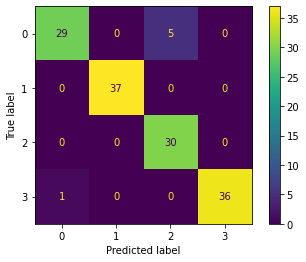

In [27]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(classifier, X_test_transform, y_test), index=['ridge on rocket']))

In [28]:
label_encoder = {label: i for i, label in enumerate(set(y_train))}
label_decoder = {i: label for label, i in label_encoder.items()}
label_encoder, label_decoder

({'epilepsy': 0, 'running': 1, 'walking': 2, 'sawing': 3},
 {0: 'epilepsy', 1: 'running', 2: 'walking', 3: 'sawing'})

In [29]:
encoded_y_train = [label_encoder[label] for label in y_train]

In [30]:
dtrain = xgb.DMatrix(X_train_transform, encoded_y_train)

In [31]:
booster = xgb.train({}, dtrain)

In [32]:
booster

In [33]:
encoded_y_test = [label_encoder[label] for label in y_test]

In [34]:
dxtest = xgb.DMatrix(X_test_transform)

<xgboost.core.Booster object at 0x0000017B2C652B80> ->
Accuracy: 0.7826
Precision: 0.8117
recall: 0.7826
F1: 0.7794



C:\Users\Lucas\AppData\Local\Temp\ipykernel_23968\152857220.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster, dxtest, encoded_y_test, _round=True), index=['xgb on rocket']))


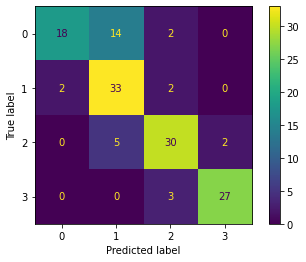

In [36]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster, dxtest, encoded_y_test, _round=True), index=['xgb on rocket']))

In [37]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1
ridge on rocket,0.956522,0.960732,0.956522,0.956507
xgb on rocket,0.782609,0.811680,0.782609,0.779438


### 30 trails with resample and average accuracy

In [2]:
class RidgeRocket:
    def __init__(self, verbose=False):
        self.rocket = Rocket()
        self.classifier = RidgeClassifier()
        self.verbose = verbose

    def fit(self, X_train, y_train):
        self.rocket.fit(X_train)
        X_train_transform = self.rocket.transform(X_train)
        self.classifier.fit(X_train_transform, y_train)
        if self.verbose:
            print('train score:', self.classifier.score(X_train_transform, y_train))

    def predict(self, X_test):
        X_test_transform = self.rocket.transform(X_test)
        return self.classifier.predict(X_test_transform)

In [37]:
class Counter:
    count = 0
    def plus(self):
        self.count += 1
        return self.count
    
    def __repr__(self):
        return str(self.count)

In [52]:
class ClassifierTester:
    res_df = pd.DataFrame()

    def __init__(self, path, klass):
        self.train = self.load(path % 'TRAIN')
        self.X_test, self.y_test = load_from_tsfile(path % 'TEST')
        self.klass = klass

    def load(self, path):
        X, y = load_from_tsfile(path)
        X['y'] = y
        return X

    def _single_train(self, i):
        X_train = resample(self.train)
        y_train = X_train.pop('y')
        classifier = self.klass()
        classifier.fit(X_train, y_train)
        return pd.DataFrame(data=print_cv_metrics(
            classifier,
            self.X_test,
            self.y_test,
            print_results=False
        ), index=[i])

    def run(self, times=30):
        with progressbar.ProgressBar(max_value=times) as bar:
            with ThreadPool(16) as pool:
                counter = Counter()
                def f(i):
                    df = self._single_train(i)
                    bar.update(counter.plus())
                    return df

                dfs = pool.map(f, range(times))

        return pd.concat(dfs)

In [53]:
tester = ClassifierTester('data/Epilepsy/Epilepsy_%s.ts', RidgeRocket)

In [54]:
res = tester.run()
res

100% (30 of 30) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


,accuracy,precision,recall,f1
0,0.942029,0.942964,0.942029,0.942395
1,0.956522,0.958966,0.956522,0.956069
2,0.978261,0.978675,0.978261,0.978369
3,0.905797,0.907149,0.905797,0.904468
4,0.949275,0.948998,0.949275,0.949042
5,0.978261,0.978275,0.978261,0.978158
6,0.942029,0.942029,0.942029,0.942029
7,0.942029,0.942964,0.942029,0.942395
8,0.963768,0.964389,0.963768,0.963981
9,0.978261,0.978275,0.978261,0.978158


In [55]:
res.describe()

,accuracy,precision,recall,f1
count,30.000000,30.000000,30.000000,30.000000
mean,0.951691,0.953026,0.951691,0.951380
std,0.019438,0.018175,0.019438,0.020049
min,0.905797,0.907149,0.905797,0.899651
25%,0.942029,0.942263,0.942029,0.942049
50%,0.952899,0.955819,0.952899,0.952717
75%,0.963768,0.964380,0.963768,0.963619
max,0.978261,0.978947,0.978261,0.978369
